In [1]:
import time
from tqdm import trange

import torch
if torch.cuda.is_available():
    torch.set_default_device("cuda")
import torch.nn.functional as F
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import levy_stable

import pyro.distributions as dist

from torcstable import StableWithLogProb, Batch1DIntegrator

# torch.autograd.set_detect_anomaly(True)

ModuleNotFoundError: No module named 'torcstable'

## Test the forward calculation against the scipy implementation

In [2]:
def test_logprob(alpha, beta, scale, loc, n):
    dist = StableWithLogProb(alpha, beta, scale, loc)
    # return dist
    x = dist.sample((n,))
    
    t0 = time.time()
    torch_log_prob = dist.log_prob(x)
    t_torch = time.time() - t0
    print(f"Torch time pre-compilation = {t_torch}")
    # print(f"{torch_log_prob=}")
    
    t0 = time.time()
    torch_log_prob = dist.log_prob(x)
    t_torch = time.time() - t0
    print(f"Torch time with compilation = {t_torch}")
    # print(f"{torch_log_prob=}")
    
    t0 = time.time()
    levy_stable.parameterization = "S0"
    scipy_log_prob = levy_stable.logpdf(x.cpu().numpy(), dist.stability.cpu().numpy(), dist.skew.cpu().numpy(), scale=dist.scale.cpu().numpy(), loc=dist.loc.cpu().numpy())
    t_scipy = time.time() - t0
    print(f"Scipy time = {t_scipy}")
    # print(f"{scipy_log_prob=}")

    difference = torch_log_prob.cpu().numpy() - scipy_log_prob
    print(f"max abs. difference = {np.abs(difference).max()}")
    print(f"max rel. difference = {(np.abs(difference) / scipy_log_prob).max()}")    

In [3]:
test_logprob(1.1, 0.1, 2.5, 3., 1000)

/home/matt/Code/emsim/emsim/stable_dist/integrator.py:117: TracerWarning: torch.Tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  torch.Tensor([n_per_dim]),
/home/matt/miniconda3/envs/emsim/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/matt/miniconda3/envs/emsim/lib/python3.11/site-packages/torch/utils/_device.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().require

Torch time pre-compilation = 0.7573554515838623
Torch time with compilation = 0.005152702331542969
Scipy time = 0.41539835929870605
max abs. difference = 0.31197633453070495
max rel. difference = -9.362936807547116e-12


## Set up a simple maxiumum likelihood problem

In [4]:
def nll_loss(dist: StableWithLogProb, data: torch.Tensor):
    ll = dist.log_prob(data).sum()
    return -ll

In [5]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self._raw_alpha = nn.Parameter(torch.randn((1,)))
        self._raw_beta = nn.Parameter(torch.randn((1,)))
        self._raw_scale = nn.Parameter(torch.randn((1,)))
        self.loc = nn.Parameter(torch.randn(1,))
        
        self.integrator = Batch1DIntegrator()
        
    @property
    def alpha(self):
        return torch.sigmoid(self._raw_alpha) * 2
    
    @property
    def beta(self):
        return torch.sigmoid(self._raw_beta) * 2 - 1
        
    @property
    def scale(self):
        return torch.exp(self._raw_scale)
        
    def params(self):
        return (
            self.alpha, self.beta, self.scale, self.loc
        )

## Defining true parameters here

In [6]:
torch.manual_seed(123)
# true = dist.Stable(1.8, 0.4, 2.5, 3.)
true_alpha = 1.1
true_beta = 0.9
true_scale = 2.5
true_loc = 1.0
true = dist.Stable(true_alpha, true_beta, true_scale, true_loc)

module = MyModule().cuda()

num_steps = 10000
batch_size = 1000

## Training loop

In [7]:
optim = torch.optim.Adam(module.parameters())
losses = []
gradients = []
param_values = []
param_errors = []
torch.manual_seed(123)
with trange(num_steps) as pbar:
    true_params = np.array([true.stability.item(), true.skew.item(), true.scale.item(), true.loc.item()])
    for i in pbar:
        t0 = time.time()
        data = true.sample((batch_size,))
        optim.zero_grad()
        training_dist = StableWithLogProb(module.alpha, module.beta, module.scale, module.loc, integrator=module.integrator)
        loss = nll_loss(training_dist, data)

        loss.backward()
        with torch.no_grad():
            grad_t = [param.grad.item() for param in module.parameters()]

        gradients.append(grad_t)

        optim.step()

        losses.append(loss.item())
        with torch.no_grad():
            params_t = np.array([param.item() for param in module.params()])
        param_values.append(params_t)
        
        param_error = np.linalg.norm(params_t - true_params, 1)
        param_errors.append(param_error)
        
        t_iter = time.time() - t0
        
        pbar.set_postfix(loss=losses[-1], param_error=param_error, iter_time=t_iter)
per_param_errors = np.abs(np.array(param_values) - true_params)

  0%|          | 0/10000 [00:00<?, ?it/s]/home/matt/miniconda3/envs/emsim/lib/python3.11/site-packages/torch/utils/_device.py:62: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/build/aten/src/ATen/core/TensorBody.h:486.)
  return func(*args, **kwargs)
100%|██████████| 10000/10000 [02:19<00:00, 71.82it/s, iter_time=0.017, loss=3.27e+3, param_error=0.196]


Text(0.5, 1.0, 'Parameter estimation errors')

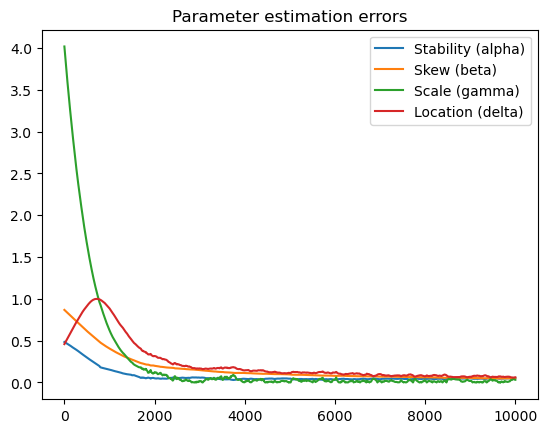

In [8]:
plt.plot(per_param_errors, label=["Stability (alpha)", "Skew (beta)", "Scale (gamma)", "Location (delta)"])
plt.legend()
plt.title("Parameter estimation errors")

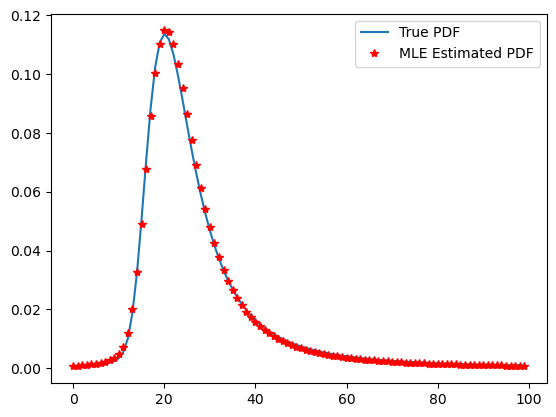

In [9]:
true_pdf = levy_stable.pdf(np.linspace(-10, 40, 100), true.stability.item(), true.skew.item(), loc=true.loc.item(), scale=true.scale.item())
estimated_pdf = levy_stable.pdf(np.linspace(-10, 40, 100), param_values[-1][0], param_values[-1][1], scale=param_values[-1][2], loc=param_values[-1][3])
plt.plot(true_pdf)
plt.plot(estimated_pdf, "r*")
plt.legend(["True PDF", "MLE Estimated PDF"])

In [10]:
# For debugging
loss = (-training_dist.log_prob(data)).sum()
loss.backward()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.